In [1]:
# Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.basic_data import *
# from fastai.callbacks import *
import os
import sys
import argparse
from copy import copy
import cv2
import imageio

PATH = Path('/home/akash/Roads/Datasets/spacenet/FINAL_DATA')

PATH.ls()

[PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/images'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/.ipynb_checkpoints'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/masks'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/temp'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/models'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/Untitled.ipynb'),
 PosixPath('/home/akash/Roads/Datasets/spacenet/FINAL_DATA/masks_1')]

In [2]:
IMAGES = PATH/'images'
MASKS = PATH/'masks_1'  # Contains masks where each road pixel has value 1 (any other value will not work)

def get_mask_name(im):
    """
    Takes in image name and returns absolute path of the corresponding mask for that image.
    This function is specific for this training.
    """
    if 'mass' in im.name:
        return str((MASKS/(im.stem + '.png')).absolute())
    root = im.name.split('_')[-1].split('.')[0]
    city = im.name.split('_')[-2]
    return str((MASKS/(city + 'mask_' + root + '.png')).absolute())

im_names = np.array(['images/'+o.name for o in IMAGES.ls()]) # Image names
mask_names = np.array([get_mask_name(o) for o in IMAGES.ls()]) # Corresponding mask names for images in im_names

In [3]:
# Making a simple sanity check on number of images and masks in the list and in the directory
len(mask_names), len(im_names), len(list(IMAGES.iterdir()))

(2899, 2899, 2899)

This section creates a `DataFrame` that pairs each image to the corresponding mask<br>
All the code below essentially depends on `PATH` and `df`<br>
You can change these to correspond to your datasets and all the code below should ideally work, atlhough I haven't tested it properly

In [4]:
df = pd.DataFrame({'images':im_names, 'masks': mask_names})

These classes are useful when the mask images do not have each Road pixel with value `1`<br>
All this does is it replaces fastai's default open_image method with one that divides each pixel value by the max value found in the image <br>
This means that if the mask has road pixels with value `150`, then it will divide each pixel by `150` to make it `= 1` <br>
We do not need to use this here, as currently our masks are the way we want them. <br>
When you do need to use this, just replace every `SegmentationLabelList` by `MySegmentationLabelList`

In [5]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

class MySegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

##### Saved models to be deleted: (Random note taking)
- model_1_spacenetonly
- model_1_spacenet_512
- model_2_mass_space_512_r34
- modeel_2_mass_space_512_r34_stage_2
- model_2_mass_space_512_r34_stage_2-5

## Modelling with Spacenet + Massachusetts

In [6]:
def get_data(size=224, bs=64):

    # get_transforms() adds many other general augmentations in addition to the specifics mentioned in the parameters
    tfms = get_transforms(flip_vert=True, max_rotate=90, max_warp=0)
    
    mass_space_data = (SegmentationItemList.from_df(df, PATH, 'images')  # PATH is the root directory for the data.
       .random_split_by_pct(0.15) # Validation set will be 15% of the traning set
       .label_from_df('masks', classes=['Background','Roads'])  # Each image will be labbeled from the 'masks' column of the dataframe
       .transform(tfms, tfm_y=True, size=size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs)).normalize(imagenet_stats)
    
    return mass_space_data

##### Digging into what just happened above : 
(You should rather visit https://docs.fast.ai/data_block.html to get a more complete sense of the code above)

- `.from_df` : `PATH` is the roor containing training images and masks <br>
             `df` contains images and corresponding masks
- `.random_split_by_pct` : `pct` is percentage of training data to be used as validation data <br>
- `.label_from_df`: 'masks' tells fast.ai to look into the 'masks' column in `df` to find masks for images
- `.transform`: `tfms` is the list of transforms to be applied to each image before training
                `tfm_y` specifies whether the corresponding transform is to be applied to the labels as well
                `size` is the final size of each image before feeding to the model <br>
                `resize_method`: How an image should ne resized <br>

### Setting up model

In [7]:
# Metric to measure PEAK Ram Usage

import tracemalloc
class TraceMallocMetric(Callback):
    def __init__(self):
        super().__init__()
        self.name = "peak RAM"

    def on_epoch_begin(self, **kwargs):
        tracemalloc.start()
        
    def on_epoch_end(self, **kwargs):
        current, peak =  tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.metric = torch.tensor(peak)

In [8]:
metrics = [dice, TraceMallocMetric()]
callbacks = [ShowGraph]

We will first train with images of size 224 and progressively increase the images size. This has been shown to help segmentation models perform better. 

In [9]:
m = unet_learner(get_data(224, 48), models.resnet34, metrics=dice, callback_fns=callbacks)

In [10]:
def find_lr(model=m):
    model.lr_find()
    model.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05


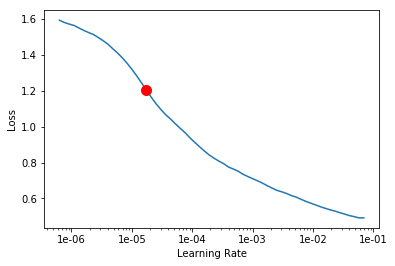

In [11]:
find_lr()

The `lrs` argument below helps in setting up differntial learning rates. <br>
Basically, the learning rates for the first layer and the last year will now be evenly geometrically spaced between
`lr/30` and `lr` <br>
This is almost always better than one constant learning rate for the entire network.<br>
Also, `fit_one_cycle` refers to the One Cycle Learning Policy https://docs.fast.ai/callbacks.one_cycle.html

In [15]:
lr = 1e-4
lrs = slice(lr/30, lr)

epoch,train_loss,valid_loss,dice
1,0.160798,0.166903,0.055996
2,0.149148,0.159664,0.049313
3,0.146915,0.157006,0.099618


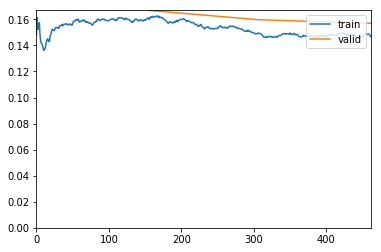

In [16]:
m.fit_one_cycle(3, lrs)

In [17]:
lr = 1e-4
lrs = slice(lr/10, lr)

epoch,train_loss,valid_loss,dice
1,0.147602,0.157141,0.081004
2,0.143840,0.161142,0.259643
3,0.140131,0.148205,0.175919
4,0.137797,0.147607,0.183798


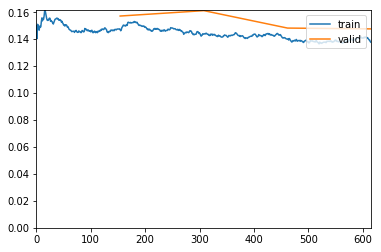

In [18]:
m.fit_one_cycle(4, lrs)

In [17]:
# m.save('M_1_FROZEN_R34_SPACE_MASS_1_03_19')

Learner(data=ImageDataBunch;

Train: LabelList (2465 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Valid: LabelList (434 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [19]:
# Continue training
m.load('M_1_FROZEN_R34_SPACE_MASS_1_03_19')

Learner(data=ImageDataBunch;

Train: LabelList (2465 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Valid: LabelList (434 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [20]:
m.data = get_data(224, 16)

In [21]:
# Now that the final layers seem to have been saturated, we will unfreeze all the layers.
# This will probably require us to reduce our batch size
m.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


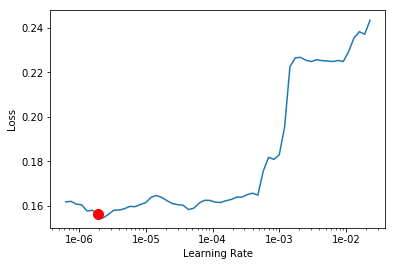

In [22]:
find_lr()

In [22]:
lr = 1e-5
lrs = slice(lr/10, lr)

epoch,train_loss,valid_loss,dice
1,0.159358,0.149441,0.030900
2,0.161172,0.150535,0.106747
3,0.155983,0.143689,0.063807
4,0.156223,0.143274,0.066997


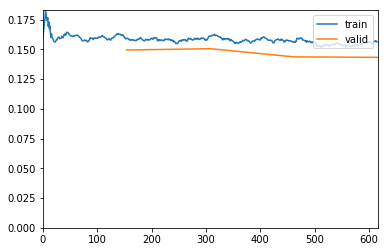

In [23]:
m.fit_one_cycle(4, lrs)

In [24]:
lr = 5e-7
lrs = slice(lr/30, lr)

epoch,train_loss,valid_loss,dice
1,0.158050,0.143427,0.071967
2,0.154839,0.143104,0.067091
3,0.155088,0.143106,0.071198
4,0.149523,0.143163,0.069667
5,0.153831,0.143139,0.071394


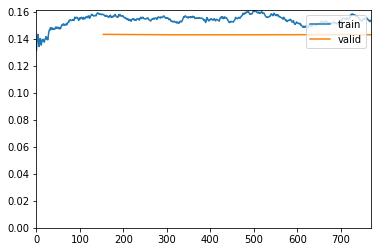

In [25]:
m.fit_one_cycle(5, lrs)

In [26]:
m.save('M_224_UNFROZEN_R34_UNET_SPACE_MASS_1_03_19')

Since this model seems to now be saturated, we will now increase our image size to `512 px`. We will also need to reduce the batch size to around ~ `8`. <br>
This should help a lot in getting the model to learn better as is apprant from the `find_lr()` output below

In [11]:
# partial is a function from the python standard functools library.
# It gives back a function which is called with a default value of the arguments passed to partial.
# Here we pass iou=True to signal that we need the iou metric and not the usual dice metric
dice_iou = [partial(dice, iou=True)]

In [12]:
m = unet_learner(get_data(512, 8), models.resnet34, metrics=dice_iou, callback_fns=callbacks)

In [14]:
m.load('M_512_UNFROZEN_R34_UNET_SPACE_MASS_1_03_19_2')

Learner(data=ImageDataBunch;

Train: LabelList (2465 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Valid: LabelList (434 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


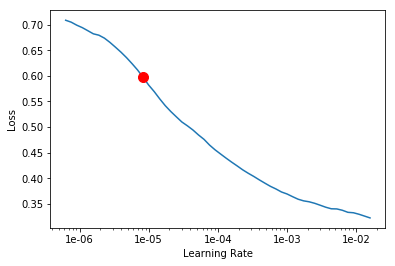

In [15]:
find_lr()

In [16]:
lr = 8.32e-6
lrs = slice(lr/20, lr)

epoch,train_loss,valid_loss,dice
1,0.103667,0.103069,0.343967
2,0.112496,0.102889,0.341515
3,0.105087,0.102379,0.351514


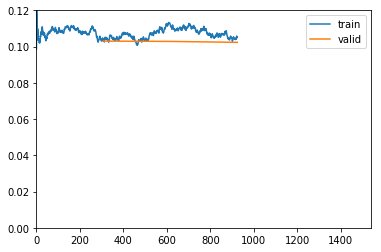

In [ ]:
m.fit_one_cycle(5, lrs)

In [ ]:
m.save('M_512_UNFROZEN_R34_UNET_SPACE_MASS_1_03_19_2')

In [15]:
m = unet_learner(get_data(1024, 2), models.resnet34, metrics=dice_iou, callback_fns=callbacks)
m.load('M_512_UNFROZEN_R34_UNET_SPACE_MASS_1_03_19_2')

Learner(data=ImageDataBunch;

Train: LabelList (2465 items)
x: SegmentationItemList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: SegmentationLabelList
ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Valid: LabelList (434 items)
x: SegmentationItemList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: SegmentationLabelList
ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024)
Path: /home/akash/Roads/Datasets/spacenet/FINAL_DATA;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, ep

In [ ]:
find_lr()

In [16]:
lr = 1e-5
lrs = slice(lr/20, lr)

epoch,train_loss,valid_loss,dice
1,0.159378,0.134898,0.185814
2,0.130591,0.126950,0.180649
3,0.139537,0.123294,0.244498
4,0.128623,0.120812,0.256715


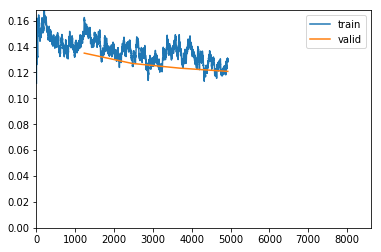

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/akash/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/akash/anaconda3/envs/pytorch/lib

KeyboardInterrupt: 

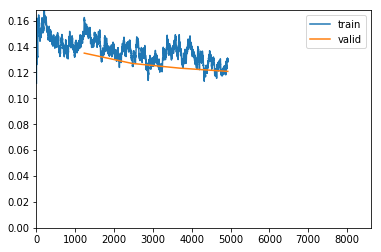

In [17]:
m.fit_one_cycle(7, lrs)

In [18]:
m.save('M_1024_UNFROZEN_R34_UNET_SPACE_MASS_1_03_19')

## Make some predictions on MMI Data

In [16]:
MMI_PATH = Path('/home/akash/Roads/mmi_dataset')

MMI_IMGS = MMI_PATH/'Images'
MMI_MASKS = MMI_PATH/'Masks'

images = ImageItemList.from_folder(MMI_IMGS)
masks = ImageItemList.from_folder(MMI_MASKS)

images

In [50]:
#10, 15

In [56]:
idx = 13

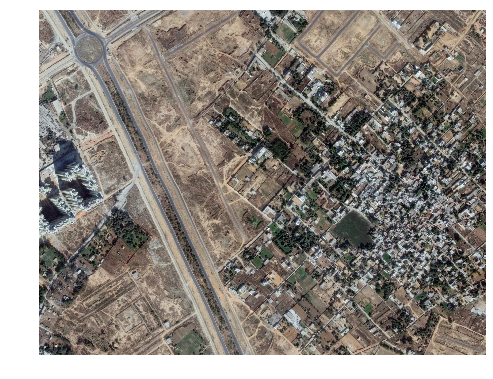

In [57]:
images[idx].show(figsize=(8,8))

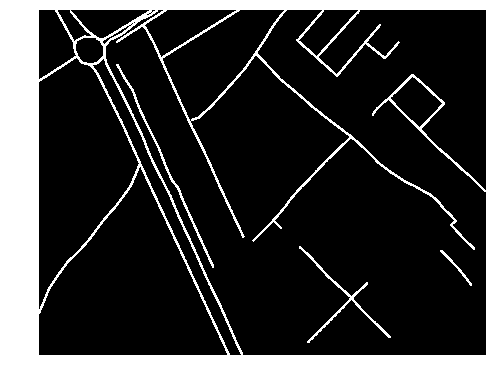

In [58]:
masks[idx].show(figsize=(8,8))

In [59]:
pred = m.predict(images[idx])

In [148]:
im = images[13]

In [149]:
im = to_np(im.data)

In [150]:
im.shape

(3, 3705, 4800)

In [151]:
hw = 2400
hh = 1850

In [152]:
im1 = im[:, 0:hh, 0:hw].transpose(1,2,0)
im2 = im[:, 0:hh, hw:].transpose(1,2,0)
im3 = im[:, hh:, 0:hw].transpose(1,2,0)
im4 = im[:, hh:, hw:].transpose(1,2,0)

In [153]:
TMP = PATH/'temp'
TMP.mkdir(exist_ok=True)

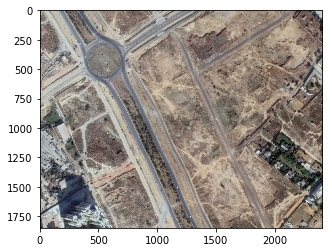

In [154]:
plt.imshow(im1)

In [155]:
# cv2.imwrite(str(TMP/'im1.png'))
imageio.imwrite(TMP/'im1.png', im1)
imageio.imwrite(TMP/'im2.png', im2)
imageio.imwrite(TMP/'im3.png', im3)
imageio.imwrite(TMP/'im4.png', im4)

In [156]:
im1 = open_image(TMP/'im1.png')
im2 = open_image(TMP/'im2.png')
im3 = open_image(TMP/'im3.png')
im4 = open_image(TMP/'im4.png')

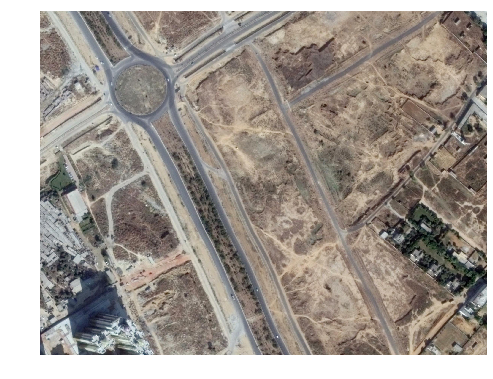

In [145]:
im1.show(figsize=(8,8))

In [157]:
pred1 = m.predict(im1)[0]
pred2 = m.predict(im2)[0]
pred3 = m.predict(im3)[0]
pred4 = m.predict(im4)[0]

In [ ]:
predd1 = pred1.data
predd2 = pred2.data
predd3 = pred3.data
predd4 = pred4.data